In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df = pd.read_excel('datasetProf.xlsx',index_col=0,parse_dates=True)
df.sort_values(by=['Date'], inplace = True)
df=df.dropna()
df=df.drop(axis=1,labels="Time")
df.head()

,Bolus Volume Delivered (U),Sensor Glucose (mg/dL),ISIG Value
Date,,,
2022-02-01,0.150,185.0,33.11
2022-02-01,0.000,175.0,31.92
2022-02-01,0.075,179.0,32.39
2022-02-01,0.175,182.0,32.63
2022-02-01,0.175,186.0,32.92


In [3]:
#eliminazioni anomalie
from numpy import percentile

q25, q75 = percentile(df, 25), percentile(df, 75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

print(lower)
print(upper)

df=df.loc[df['Sensor Glucose (mg/dL)']>lower]
df=df.loc[df['Sensor Glucose (mg/dL)']<upper]

df.head()

-151.0625
252.2375


,Bolus Volume Delivered (U),Sensor Glucose (mg/dL),ISIG Value
Date,,,
2022-02-01,0.150,185.0,33.11
2022-02-01,0.000,175.0,31.92
2022-02-01,0.075,179.0,32.39
2022-02-01,0.175,182.0,32.63
2022-02-01,0.175,186.0,32.92


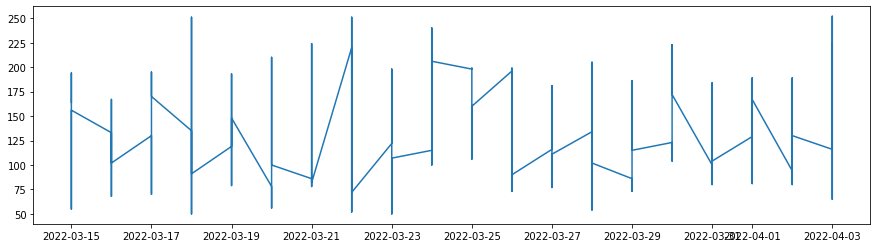

In [4]:
import datetime

start_train = str(datetime.datetime(2022, 2, 1,0,0))
end_train = str(datetime.datetime(2022, 3, 14, 0, 0)) #un mese e due settimane per il training
start_test = str(datetime.datetime(2022, 3, 15,0,0))
end_test = str(datetime.datetime(2022, 4, 3 , 0, 0)) #tre settimane per il testing
start_validation=str(datetime.datetime(2022, 4, 4, 0, 0))
end_validation = str(datetime.datetime(2022, 4, 4, 23, 59)) #un giorno per la validazione

#Prendiamo i dati necessari per il training
df_train=df.loc[start_train:end_train]
X_train=df_train.drop("Sensor Glucose (mg/dL)", axis=1).values
Y_train=df_train["Sensor Glucose (mg/dL)"].values

#Prendiamo i dati necessari per il testing
df_test=df.loc[start_test:end_test]
X_test=df_test.drop("Sensor Glucose (mg/dL)", axis=1).values
Y_test=df_test["Sensor Glucose (mg/dL)"].values

plt.figure().set_figwidth(15)
plt.plot(df_test.index,Y_test)

In [5]:
#Standardizziamo i dati e alleniamo il regressore

pipe=make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train,Y_train)

#Facciamo la nostra predizione sui dati di testing
Y_pred = pipe.predict(X_test)

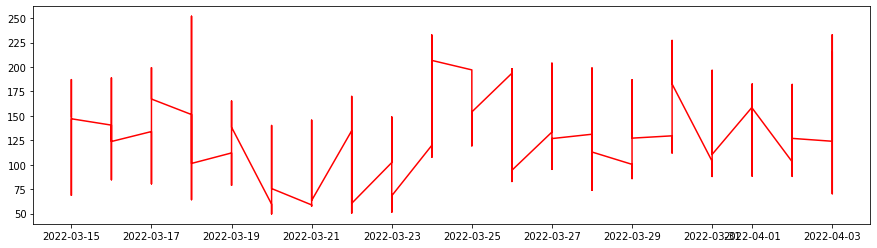

In [6]:
plt.figure().set_figwidth(15)
plt.plot(df_test.index,Y_pred,color='red')

In [7]:
errore = mean_squared_error(Y_test, Y_pred)
print("Errore:", errore)
punteggio = r2_score(Y_test, Y_pred)
print("Score:", punteggio)

Errore: 414.95936947477736
Score: 0.7063803048355112


In [8]:
#A questo punto vediamolo considerando anche l'ora del giorno così da avere un grafico più preciso:
#rileggo il dataset perchè prima non avevo usato il timestamp
df = pd.read_excel('datasetProf.xlsx')
df=df.dropna() #toglie le righe dove ci sono ISIG o GLICEMIA nulli
df["timestamp"]=df['Date'].astype(str) +" "+ df["Time"].astype(str)
df=df.drop(axis=1,labels="Date")
df=df.drop(axis=1,labels="Time")
df.set_index("timestamp",drop=True,inplace=True)
df.sort_values(by=['timestamp'], inplace = True)
df.index = pd.to_datetime(df.index)

from numpy import percentile

q25, q75 = percentile(df, 25), percentile(df, 75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

print(lower)
print(upper)

df=df.loc[df['Sensor Glucose (mg/dL)']>lower]
df=df.loc[df['Sensor Glucose (mg/dL)']<upper]

df.head()

-151.0625
252.2375


,Bolus Volume Delivered (U),Sensor Glucose (mg/dL),ISIG Value
timestamp,,,
2022-02-01 23:05:00,0.150,185.0,33.11
2022-02-01 23:10:01,0.175,186.0,32.84
2022-02-01 23:15:00,0.150,186.0,32.81
2022-02-01 23:20:09,0.230,187.0,33.16
2022-02-01 23:25:01,0.175,189.0,33.45


([<matplotlib.axis.XTick at 0x7f1f96837310>,
 <a list of 41 Text major ticklabel objects>)

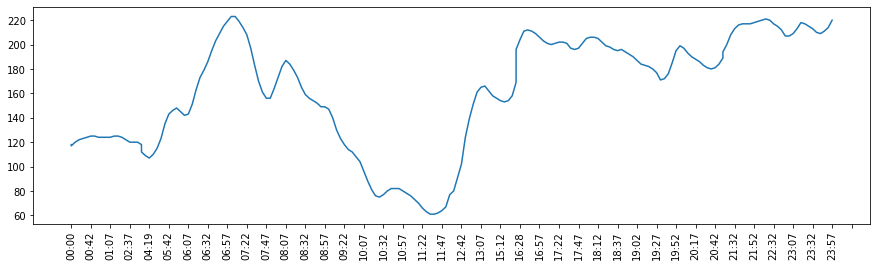

In [9]:
import datetime

#qui prendo i dati per la validazione: giornata del 4 aprile
df_One=df.loc[start_validation:end_validation] 

Y_One=df_One["Sensor Glucose (mg/dL)"].values #valori reali del 4 aprile
X_One=df_One.drop("Sensor Glucose (mg/dL)", axis=1).values

fig=plt.figure()
fig.set_figwidth(15)
labels = df_One.index.strftime('%H:%M')
plt.plot(labels,Y_One)
plt.xticks(rotation=90) #i xticks sono i 'tick' sull'asse delle x, rotation=90 è per metterli in verticale
plt.xticks(np.arange(0, len(labels), 5)) 

In [10]:
#pipe=make_pipeline(StandardScaler(), LinearRegression())
#pipe.fit(X_train,Y_train)
#Y_pred = pipe.predict(X_test)

#Y_predOneLinear=Y_pred[(len(Y_pred)-lengthLast-lengthOne):(len(Y_pred)-lengthLast)] #parto dalla fine-gli elementi dell'ultimo giorno- gli elementi del penultimo giorno fino a (fine-elementi ultimo giorno)

#fig=plt.figure()
#fig.set_figwidth(15)
#labels = df_One.index.strftime('%H:%M')
#plt.plot(labels,Y_predOneLinear,color='red')
#plt.plot(labels,Y_One,color='green')
#plt.xticks(rotation=90) #i xticks sono i 'tick' sull'asse delle x, rotation=90 è per metterli in verticale
#plt.xticks(np.arange(0, len(labels), 5))

In [11]:
#Facciamo la nostra predizione sui dati di validation
Y_pred = pipe.predict(X_One)

print(len(Y_pred))
print(len(Y_One))

203
203


([<matplotlib.axis.XTick at 0x7f1f96cda1d0>,
 <a list of 41 Text major ticklabel objects>)

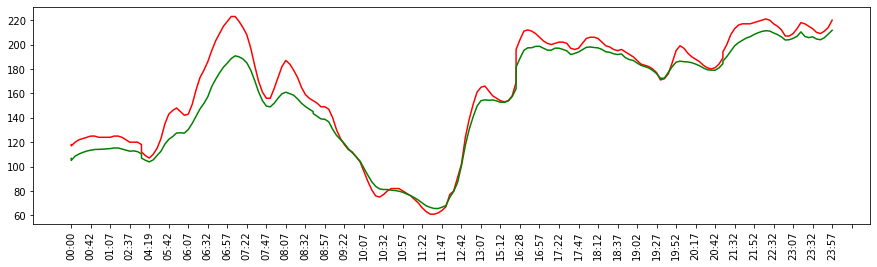

In [12]:
fig=plt.figure()
fig.set_figwidth(15)
labels = df_One.index.strftime('%H:%M')
plt.plot(labels,Y_One,color='red') #valori reali
plt.plot(labels,Y_pred,color='green') #previsione
plt.xticks(rotation=90) #i xticks sono i 'tick' sull'asse delle x, rotation=90 è per metterli in verticale
plt.xticks(np.arange(0, len(labels), 5))

In [13]:
errore = mean_squared_error(Y_One, Y_pred)
print("Errore:", errore)
punteggio = r2_score(Y_One, Y_pred)
print("Score:", punteggio)

Errore: 135.8436356935951
Score: 0.936477717929199
